# Load Modules

In [1]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import os
import sys


from tqdm import tqdm # Not required


Proj_Root = os.path.join(os.pardir)

# Load Data 

In [2]:
# Image path generator
images = []
path_img = os.path.join(Proj_Root, "data/processed/training/")
for (dirName, dirs, filelist) in os.walk(path_img):
    for file in filelist:
        if file.endswith('.png'):
            abs_path = os.path.join(dirName, file)
            images.append(abs_path)

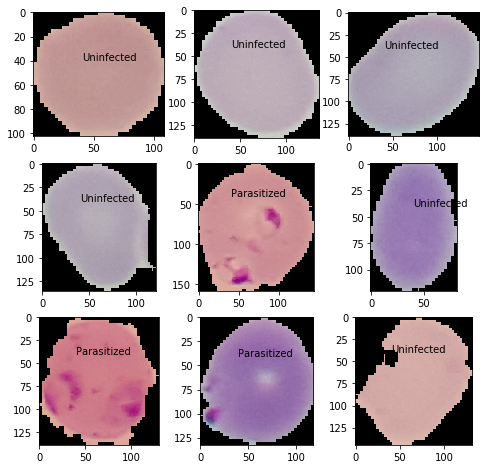

In [3]:
def plot_images():
    fig = plt.figure(figsize=(8,8))
    cols = 3
    rows = 3
    for i in range(1,cols*rows+1):
        sample_image = random.choice(images)
        img = mpimg.imread(sample_image)
        sample_label = sample_image.split('/')[-2]
        fig.add_subplot(rows, cols, i)
        plt.imshow(img)
        plt.text(40, 40, sample_label)
plot_images()
plt.savefig('../reports/figures/SampleData.png')

> As we can see here cells with red spots are `Infected`. A clinician is supposed to detect and count this red blood cells to identify Maleria cases.

In [4]:
# Add the 'src' directory as one where we can import modules
src_data= '../src/data/'

sys.path.append(src_data)

import config
import pathgen
import get_data


In [44]:
# Get converted image data
from get_data import get_data
X_train, X_val, X_test, Y_train, Y_val, Y_test = get_data() 

100%|██████████| 30882/30882 [02:59<00:00, 172.47it/s]


In [1]:
info = {'TrainSet': (len(X_train), X_train[0].shape),
        'ValidationSet': (len(X_val), X_val[0].shape),
        'TestSet': (len(X_test), X_test[0].shape)}


shapes = pd.DataFrame(info, columns=['Samples', 'Height', 'Width', 'Color'])


NameError: name 'X_train' is not defined

# Data Preprocessing

A pixel’s color can be represented using 3 color values (assume RGB color channel) so a pixel holds a list of 3 values (1 value for r, 1 value for g and 1 value for b of RGB channel). We code this in a similar structure, but we create 64 x 64 values of r, followed by 64 x 64 values of g, followed by 64 x 64 values of b. That’s a total of 12288 values in a vector for only one image.

In [55]:
# Reshape and scale 
train_images = X_train[0].reshape((-1, 64*64*3))
train_images = train_images[0].astype('float32') / 255

validation_images = X_val[0].reshape((-1, 64*64*3))
validation_images = validation_images[0].astype('float32') / 255

test_images = X_test[0].reshape((-1, 64*64*3))
test_images = test_images[0].astype('float32') / 255

In [68]:
# # Preparing labels: categorically encode the labels
# from keras.utils import to_categorical

# train_labels = to_categorical(Y_train)
# validation_labels = to_categorical(Y_val)
# test_labels = to_categorical(Y_test)
# Turns out we have already done that 
train_labels = np_utils.to_categorical(Y_train,2)
validation_labels = Y_val
test_labels = Y_test

## View Sample Cell Images

In [57]:
train_images.shape

(12288,)

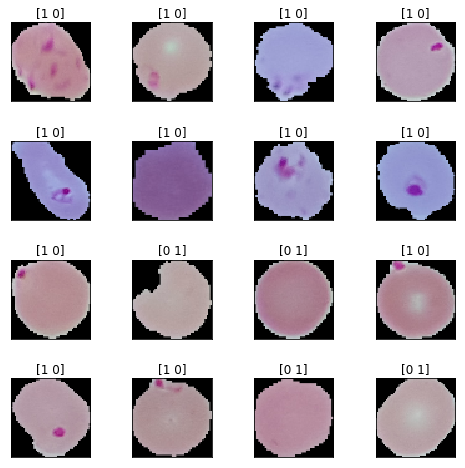

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(1 , figsize = (8 , 8))
n = 0 
for i in range(16):
    n += 1 
    r = np.random.randint(0 , X_train.shape[0] , 1)
    plt.subplot(4 , 4 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(X_train[r[0]])
    plt.title('{}'.format(Y_train[r[0]]))
    plt.xticks([]) , plt.yticks([])

This cell images are reshaped to (64, 64, 3) and class names are decoded as follows:

[1 0] shows Malaria cell

[0 1] shows Health cell

# KNN

The k-Nearest Neighbor classifier is by far the most simple machine learning and image classi- fication algorithm. In fact, it’s so simple that it doesn’t actually “learn” anything. Instead, this algorithm directly relies on the distance between feature vectors. Each data point in the k closest data points casts a vote, and the category with the highest number of votes wins. Or the category with the largest number of votes in the k closest training points wins and is used as the label for the input data point.

This is how KNN works in the background:
- Calculate the distance between the new point and every other point
- Sort the distances
- Pick K minimum distances from the list of sorted distances 
- Use majrity voting to get the color/label of the point

In [11]:
# show some information on memory consumption of the images
print("[INFO] training features matrix: {:.1f}MB".format(train_images.nbytes / (1024 * 1000.0)))

[INFO] training features matrix: 1071.8MB


In [12]:
# fit KNN

from sklearn.neighbors import KNeighborsClassifier
# number of neighbors
k = 5
model_knn = KNeighborsClassifier(n_neighbors=k,n_jobs=-1)
model_knn.fit(train_images, train_labels)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform')

KNN has two tuning parameters one being K, the other is the distance metric used (L1, L2 etc). We can check for hyper parameter tuning but this is out of the scope of this project so let's fit training KNN model to `validation` data.

In [13]:
# predict 

# create target names list
'''[ expression if conditional else other thing for this many times ] '''
labels_array = np.array(['parasitized' if i == 1 else 'uninfected' for i in validation_labels[:,0]])
target_names = np.unique(labels_array).tolist()

# predict classes by fitting trained model to unseen data
prediction_knn = model_knn.predict(validation_images)

Image was taken from Quora/ Joel Chan


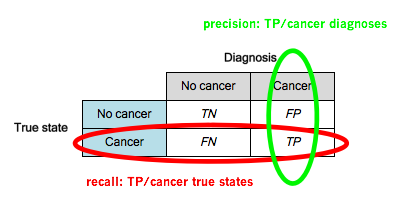

In [15]:
from IPython.display import Image
path_im = "../reports/figures/precision_recall2.png"
print("Image was taken from Quora/ Joel Chan")
Image(filename=path_im, width=750, height=750)

In [16]:
# results

acc = model_knn.score(validation_images, validation_labels)
print("[INFO] raw pixel accuracy: {:.2f}%".format(acc*100))

[INFO] raw pixel accuracy: 60.36%


In [17]:
from sklearn.metrics import classification_report
print(classification_report(validation_labels, prediction_knn, target_names=target_names))

              precision    recall  f1-score   support

 parasitized       0.73      0.35      0.48      1403
  uninfected       0.56      0.86      0.68      1354

   micro avg       0.60      0.60      0.60      2757
   macro avg       0.65      0.61      0.58      2757
weighted avg       0.65      0.60      0.58      2757
 samples avg       0.60      0.60      0.60      2757



- As you can see from `support`, we do have a good distriutio of class samples which prevents unbalanced dataset problems. 
- We have got 60 % accuracy score with KNN which is not too bad even with this not learning method, given that the probability of randomly guessing the correct class is 50 %. 
- KNN model correctly classified parasitized blood cells 73 % of the time. These are the cells with red dots.
- Looks like KNN did a better job on classifiying `uninfected` class based on the F1 score. The harmonic mean is generally used instead of the standard arithmetic mean when dealing with rates. So we use harmonic mean to get F1 score which is simply just the average of precision and recall.  
- Now that we have obtained a baseline for image classification using the k-NN algorithm, we can move on the parameterized learning, the foundation on which all deep learning and neural networks are built on. Using parameterized learning, we can actually learn from our input data and discover underlying patterns

# Simple Neural Nets

In [69]:
from keras import models
from keras import layers

# Build model arhcitechture for two class classification
model_f = models.Sequential()
# Add a fully connected hidden layer with x number of hidden units
model_f.add(layers.Dense(32, activation='relu', input_shape=(64*64*3,)))
# Add output layer with x number of nodes which equals to # classes
model_f.add(layers.Dense(2, activation='softmax')) # sigmoid 

# Compile optimizer, loss function and metrics
model_f.compile(optimizer='rmsprop',
                loss='binary_crossentropy', # binary cross 
                metrics=['accuracy'])

In [71]:
train_labels.shape

(25013, 2)

In [70]:
model_f.fit(train_images, train_labels, epochs=5, batch_size=128)

ValueError: Error when checking input: expected dense_11_input to have shape (12288,) but got array with shape (1,)

# Conv Net

# Pretrained Model

# Transfer Learning Model

# Results